In [1]:
## Importing all the libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import os
from math import *
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
## Read the input data files 

path = "C:/Users/XABARBAD/Desktop/Work/KPI Validation & Importance/Model 2/KPI_New_Files/Datasets/"
df = pd.read_excel(path+"Inter_Files.xlsx",sheet_name = "US_Files_New")

In [3]:
## Look at the input file

df

Title  Nielsen - Metrics First Choice_mean  \
0                              A Way Out                             0.003324   
1                                 Anthem                             0.021288   
2              Assassin's Creed: Odyssey                             0.005696   
3              Assassin's Creed: Origins                             0.010245   
4                          Battlefield V                             0.009903   
..                                   ...                                  ...   
66  Tom Clancy's Ghost Recon: Breakpoint                             0.002216   
67           Tom Clancy's The Division 2                             0.008961   
68                                 UFC 3                             0.002975   
69                           World War Z                             0.006745   
70                              WWE 2K19                             0.005746   

    Nielsen - Metrics Purchase interest - Def_mean  \
0                                         0.207846   
1                                         0.136293   
2                                         0.215052   
3                                         0.233635   
4                                         0.204785   
..                                             ...   
66                                        0.136837   
67                                        0.145067   
68                                        0.151768   
69                                        0.160669   
70                                        0.152796   

    Nielsen - Metrics Purchase interest - Def not_mean  \
0                                            0.212072    
1                                            0.229686    
2                                            0.151235    
3                                            0.150802    
4                                            0.178243    
..                                                ...    
66                                           0.239814    
67                                           0.244307    
68                                           0.245504    
69                                           0.256002    
70                                           0.277540    

    Nielsen - Metrics Purchase interest - Own/Preorder_mean  \
0                                            0.008650         
1                                            0.014011         
2                                            0.018241         
3                                            0.027777         
4                                            0.023763         
..                                                ...         
66                                           0.015726         
67                                           0.016775         
68                                           0.027153         
69                                           0.016303         
70                                           0.016891         

    Nielsen - Metrics Purchase interest - Prob_mean  \
0                                          0.353137   
1                                          0.327825   
2                                          0.460379   
3                                          0.475638   
4                                          0.426457   
..                                              ...   
66                                         0.316986   
67                                         0.333691   
68                                         0.334008   
69                                         0.327904   
70                                         0.331239   

    Nielsen - Metrics Unaided Awareness_mean  Google_US_mean  \
0                                   0.037278        0.897395   
1                                   0.092430        4.192914   
2                                   0.028014        3.484014   
3                                   0.0397

In [4]:
#### Functions to transform columns

def logTransform(x):
    if(x<=0):
        return 0
    else:
        return log(x)
    
def squareTransform(x):
    return pow(x,2)

def cubeTransform(x):
    return pow(x,3)

def squareRootTransform(x):
    if(x<=0):
        return 0
    else:
        return sqrt(x)

def cubeRootTransform(x):
    if(x<=0):
        return 0
    else:
        return x**(1./3)

In [5]:
#In case there are any missing values, replace them with the mean

def imputeData(df,titleColName):
    df1 = df.drop([titleColName],axis=1)
    imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
    imputer.fit(df1.values)
    df2 = pd.DataFrame(imputer.transform(df1))
    df2.columns = df1.columns
    df2.index = df1.index
    df3 = pd.concat([df[[titleColName]],df2],axis=1)
    return df3

df = imputeData(df, 'Title')

In [6]:
#Apply transformation to every column in the dataset

def getTransformedDF(df,titleColName):
    df2 = df.drop([titleColName],axis=1)
    cols = df2.columns
    df1 = df2[cols]
    for col in cols:
        df1['log('+col+')'] = df1[col].apply(lambda x:logTransform(x))
        df1['square('+col+')'] = df1[col].apply(lambda x:squareTransform(x))
        df1['cube('+col+')'] = df1[col].apply(lambda x:cubeTransform(x))
        df1['squareRoot('+col+')'] = df1[col].apply(lambda x:squareRootTransform(x))
        df1['cubeRoot('+col+')'] = df1[col].apply(lambda x:cubeRootTransform(x))
    df3 = pd.concat([df[[titleColName]],df1],axis=1)
    return df3

titleColName = 'Title'
df_transformed = getTransformedDF(df,titleColName)
df_transformed.shape

(71, 433)

In [8]:
#Export the dataset to create the correlation plot in R
#df_transformed.to_excel(path+"//Pre_launch_Corr_dataset_new_625.xlsx")

In [10]:
### Get Col Names in Sequence so as to clearly visualise correlation
### Can be skipped
#def getColsListSortedOrder(colsList,cols):
#    colsNewList = []
#    for stg in colsList:
#        for col in cols:
#            if(col.find(stg)!=-1):
#                colsNewList.append(col)
#
#    for col in cols:
#        if col not in colsNewList:
#            colsNewList.append(col)
#        
#    unique_col_list  = []    
#    for col in colsNewList:
#        if(col not in unique_col_list):
#            unique_col_list.append(col)
#    
#    return unique_col_list

In [11]:
#Get the shape of the dataset
df.shape

(71, 73)

In [2]:
#Checking the distribution of US Revenue to identify outliers
%matplotlib inline
import matplotlib.pyplot as plt
df_transformed.hist(column = 'US_Revenue',bins = 50, figsize = (20,15))
plt.show()

In [13]:
#Remove outliers based on business knowledge and the above plot.

titles = ['Call of Duty: Black Ops IIII','Call of Duty: WWII','Red Dead Redemption II', 
         'Call of Duty: Modern Warfare 2019']

df_transformed = df_transformed[~df_transformed.Title.isin(titles)]
df_transformed.shape

(67, 433)

In [14]:
#Removing more outliers by removing titles with revenue less than 16M
#16M was identified as the threshold because they had high error & we earlier saw a drop in error by deleting these

#Greater_than2m = df_transformed.US_Revenue > 16000000
#print(df_transformed[Greater_than2m].shape)
#df_transformed = df_transformed[Greater_than2m]

In [15]:
#### Linear Regression - Model 1
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

def getSplitTrainTest(df_X,df_Y,testSize,seed):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=seed)
    return (X_train,X_test,Y_train,Y_test)

def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,rank):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    dfResid = len(yoriginal) - rank
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/dfResid
    return adjusted_r_squared
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))

### For VIF Analysis
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [17]:
#Dropping title since it's a categorical variable & Revenue because we're checking for Variance inflation & don't
#need the dependent variable

df_revenue_model = df_transformed.drop(['US_Revenue', 'Title','log(US_Revenue)','cube(US_Revenue)',
                                       'squareRoot(US_Revenue)','cubeRoot(US_Revenue)','square(US_Revenue)'], axis = 1)
df_revenue_vif  = df_revenue_model.loc[:].astype(float)
df_revenue_vif.shape

(67, 426)

In [18]:
#Checking the Variance inflation factor of the independent variables

revenue_vif = variance_inflation_factors(df_revenue_vif)
revenue_vif
revenue_vif.shape

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(427,)

In [19]:
#Another method defined to calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [20]:
#Drop columns with VIF higher than the threshold defined earlier - 5.0

df_vif = calculate_vif_(df_revenue_vif)
df_vif.shape
df_vif.columns

dropping 'cube(Netbase - Metrics Mentions_mean)' at index: 163
dropping 'cube(Netbase - Metrics Posts_mean)' at index: 167
dropping 'cube(Marketing Metrics PR Metrics and Articles_max)' at index: 256
dropping 'cube(Tubular - Metrics Views_mean)' at index: 153
dropping 'cube(Marketing Metrics PR Metrics and Articles_mean)' at index: 113
dropping 'cube(Tubular - Metrics Views_max)' at index: 293
dropping 'cube(Netbase - Metrics Impressions_mean)' at index: 156
dropping 'cube(Marketing Metrics Unaided Awareness_mean)' at index: 132
dropping 'square(Tubular - Metrics Views_mean)' at index: 150
dropping 'cube(Marketing Metrics UCGs_max)' at index: 275
dropping 'cube(Tubular - Metrics Engagements_max)' at index: 279
dropping 'square(Tubular - Metrics Engagements_mean)' at index: 140
dropping 'cube(Tubular - Metrics Uploads_mean)' at index: 145
dropping 'square(Tubular - Metrics Views_max)' at index: 285
dropping 'cube(Marketing Metrics Twitter Activity_max)' at index: 258
dropping 'square(Ne

Index(['Nielsen - Metrics First Choice_mean',
       'Nielsen - Metrics Purchase interest - Def_mean',
       'Nielsen - Metrics Purchase interest - Def not_mean',
       'Nielsen - Metrics Purchase interest - Own/Preorder_mean',
       'Nielsen - Metrics Purchase interest - Prob_mean',
       'Nielsen - Metrics Unaided Awareness_mean', 'Google_US_mean',
       'Marketing Metrics Net Sentiment_mean',
       'Marketing Metrics Purchase Intent_mean',
       'Marketing Metrics Views_mean',
       ...
       'log(Metacritic Score)', 'square(Metacritic Score)',
       'cube(Metacritic Score)', 'squareRoot(Metacritic Score)',
       'cubeRoot(Metacritic Score)', 'log(User Review Score)',
       'square(User Review Score)', 'cube(User Review Score)',
       'squareRoot(User Review Score)', 'cubeRoot(User Review Score)'],
      dtype='object', length=335)

In [19]:
#Trying out variable selections. 
#Checking correlation.
#cols_corr = ['US_Revenue','squareRoot(Nielsen - Metrics Unaided Awareness_mean)',
#            'Nielsen - Metrics First Choice_mean','cube(Nielsen - Metrics Purchase interest - Def_mean)',
#            'squareRoot(Tubular - Metrics Views_mean)','Youtube_US_mean','Google_US_mean',
#            'squareRoot(Marketing Metrics Net Sentiment_mean)', 'cube(Tubular - Metrics Engagements_mean)',
#           'cube(Netbase - Metrics Mentions_mean)']
#df_corr = df_transformed[cols_corr]

In [20]:
#Using Pearson correlation
#import seaborn as sns
#plt.figure(figsize = (12,10))
#cor = df_corr.corr()
#sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)
#plt.show()

In [21]:
#Correlation with output variable
#cor_target = abs(cor["US_Revenue"])

#Selecting highly correlated features
#relevant_features = cor_target[cor_target > 0.5]
#relevant_features

#print(df_corr[["Youtube_US_mean", "Google_US_mean"]].corr())

In [22]:
#Wrapper method for variable selection.
#Backward elimination. 

df_rev_only = df_transformed.drop(['Title','log(US_Revenue)','cube(US_Revenue)','squareRoot(US_Revenue)','cubeRoot(US_Revenue)','square(US_Revenue)'], axis = 1)
df_rev  = df_rev_only.loc[:].astype(float)
df_rev.shape

#In backward elimination - we only keep variables > 0.5
X = df_rev.drop(['US_Revenue'], axis = 1)
#X.shape
y_name = "US_Revenue"
Y = df_rev[y_name]
#Y.shape

In [23]:
#Backward elimination continued - 
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

X_1 = sm.add_constant(X)

#Fitting sm.ols model
model = sm.OLS(Y,X_1).fit()
model.pvalues

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


const                                                      0.177390
Nielsen - Metrics First Choice_mean                        0.190065
Nielsen - Metrics Purchase interest - Def_mean             0.193454
Nielsen - Metrics Purchase interest - Def not_mean         0.160651
Nielsen - Metrics Purchase interest - Own/Preorder_mean    0.481979
                                                             ...   
log(User Review Score)                                     0.459479
square(User Review Score)                                  0.459951
cube(User Review Score)                                    0.458340
squareRoot(User Review Score)                              0.460100
cubeRoot(User Review Score)                                0.460138
Length: 427, dtype: float64

In [24]:
#Backward elimination of variables with p-value > 0.05
cols = list(X.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['cube(Marketing Metrics PR Metrics and Articles_mean)', 'cube(Marketing Metrics Views_mean)', 'cube(Marketing Metrics Unaided Awareness_mean)', 'square(Tubular - Metrics Views_mean)', 'cube(Tubular - Metrics Views_mean)', 'cube(Netbase - Metrics Impressions_mean)', 'cube(Netbase - Metrics Totalreplies_mean)', 'square(Reach_mean)', 'cube(Reach_mean)', 'cube(Marketing Metrics Purchase Intent_max)', 'cube(Marketing Metrics Twitter Activity_max)', 'square(Marketing Metrics Views_max)', 'cube(Marketing Metrics Views_max)', 'cube(Marketing Metrics Unaided Awareness_max)', 'cube(Marketing Metrics UCGs_max)', 'square(Tubular - Metrics Views_max)', 'square(Netbase - Metrics Impressions_max)', 'cube(Netbase - Metrics Impressions_max)', 'cube(Netbase - Metrics Posts_max)', 'cube(Netbase - Metrics Totalreplies_max)', 'square(Net Sentiment_max)', 'cube(Article Count_max)', 'square(Reach_max)', 'square(Sentiment_positive_max)', 'log(Franchise or Not)', 'log(Prem SKU 3 months)', 'log(Genre_Action_Ad

In [25]:
#Importing the relevant packages.
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

#Trying RFE on this model
df_rfe_model = df_rev_only[cols]
df_rfe_complete = df_rev_only

#Initializing the model
model = LinearRegression()

rfe = RFE(model,7)

#Transforming the data using RFE.
X_rfe = rfe.fit_transform(X,Y)

#Fitting the data to the model.
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [26]:
#This part is to identify the top variables to be later used in the model

#What is the ideal set of variables.
#No of features.
#df_rev_complete = df_rev_only

nof_list = np.arange(1,30)
high_score = 0

X = df_rev_only.drop(['US_Revenue'], axis = 1)
X = X[cols]

X.shape
y_name = "US_Revenue"
Y = df_rev_only[y_name]
Y.shape

#Variable to store the optimum features.
nof = 0
score_list = []
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features 3
Score with 3 features: 0.222550


In [27]:
#Listing the top variables to be used in the model later
#This is a good point to check which variables make sense to be kept in the model & which to be removed

cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model,20)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)

#Fitting the data to the model
model.fit(X_rfe, Y)
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

Index(['cube(Marketing Metrics PR Metrics and Articles_mean)',
       'cube(Marketing Metrics Unaided Awareness_mean)',
       'square(Tubular - Metrics Views_mean)',
       'cube(Tubular - Metrics Views_mean)',
       'cube(Netbase - Metrics Totalreplies_mean)', 'square(Reach_mean)',
       'cube(Marketing Metrics Purchase Intent_max)',
       'cube(Marketing Metrics Twitter Activity_max)',
       'square(Marketing Metrics Views_max)',
       'cube(Marketing Metrics Unaided Awareness_max)',
       'cube(Marketing Metrics UCGs_max)',
       'square(Tubular - Metrics Views_max)',
       'square(Netbase - Metrics Impressions_max)',
       'cube(Netbase - Metrics Posts_max)',
       'cube(Netbase - Metrics Totalreplies_max)', 'square(Net Sentiment_max)',
       'cube(Article Count_max)', 'square(Reach_max)',
       'square(Sentiment_positive_max)', 'cube(User Review Score)'],
      dtype='object')


In [105]:
#cols_vif = ['log(Marketing Metrics PR Metrics and Articles_mean)','log(Marketing Metrics Unaided Awareness_mean)',
#            'log(Marketing Metrics UCGs_mean)','log(Netbase - Metrics Mentions_mean)','log(Netbase - Metrics Posts_mean)',
#            'Youtube_US_mean','Google_US_mean','cube(Tubular - Metrics Views_mean)','log(Netbase - Metrics Totalreposts_mean)']

In [58]:
#Selecting the top metrics from the above method + business context
cols_vif = ['squareRoot(Nielsen - Metrics Unaided Awareness_mean)',
            'Nielsen - Metrics First Choice_mean','cube(Nielsen - Metrics Purchase interest - Def_mean)',
            'squareRoot(Tubular - Metrics Views_mean)','Google_US_mean',
            'squareRoot(Marketing Metrics Net Sentiment_mean)', 'cube(Tubular - Metrics Engagements_mean)',
           'cube(Netbase - Metrics Mentions_mean)','cube(Netbase - Metrics Impressions_mean)','cube(Netbase - Metrics Totalreplies_mean)', ]

In [59]:
#Selecting the top metrics from the above method + business context
#aftermath_cols = ['squareRoot(Nielsen - Metrics Unaided Awareness_mean)',
#            'Nielsen - Metrics First Choice_mean','cube(Nielsen - Metrics Purchase interest - Def_mean)',
#            'squareRoot(Tubular - Metrics Views_mean)','Youtube_US_mean','Google_US_mean',
#           'cube(Netbase - Metrics Mentions_mean)', 'cube(Reach_mean)', 'cube(Article Count_mean)']

In [60]:
#Subset the dataset & keep only the important variables

df_rev_vif = df_revenue_vif[cols_vif]
df_rev_vif.shape

(67, 10)

In [61]:
#df_vif = df_vif[cols_vif]
#df_vif.shape

In [62]:
### For VIF Analysis -- to ensure that the VIF thresholds aren't crossed in the subsetted variables

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [63]:
#Checking the VIF output for the subsetted variables
vif = variance_inflation_factors(df_rev_vif)
vif = vif.reset_index()
vif = vif.sort_values(by=['VIF'],ascending=0)
vif

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


index       VIF
4            squareRoot(Tubular - Metrics Views_mean)  1.297360
7            cube(Tubular - Metrics Engagements_mean)  1.070401
10          cube(Netbase - Metrics Totalreplies_mean)  1.018736
8               cube(Netbase - Metrics Mentions_mean)  1.014076
9            cube(Netbase - Metrics Impressions_mean)  0.998616
2                 Nielsen - Metrics First Choice_mean  0.596182
3   cube(Nielsen - Metrics Purchase interest - Def...  0.558837
5                                      Google_US_mean  0.456223
1   squareRoot(Nielsen - Metrics Unaided Awareness...  0.185494
6    squareRoot(Marketing Metrics Net Sentiment_mean)  0.034339
0                                               const  0.000000

In [64]:
#Checking for correlation in the dataset
df_rev_vif.corr()

squareRoot(Nielsen - Metrics Unaided Awareness_mean)  \
squareRoot(Nielsen - Metrics Unaided Awareness_...                                           1.000000      
Nielsen - Metrics First Choice_mean                                                          0.906087      
cube(Nielsen - Metrics Purchase interest - Def_...                                           0.383384      
squareRoot(Tubular - Metrics Views_mean)                                                     0.342103      
Google_US_mean                                                                               0.426036      
squareRoot(Marketing Metrics Net Sentiment_mean)                                             0.010780      
cube(Tubular - Metrics Engagements_mean)                                                     0.119993      
cube(Netbase - Metrics Mentions_mean)                                                       -0.074597      
cube(Netbase - Metrics Impressions_mean)                                                     0.100241      
cube(Netbase - Metrics Totalreplies_mean)                                                    0.134747      

                                                    Nielsen - Metrics First Choice_mean  \
squareRoot(Nielsen - Metrics Unaided Awareness_...                             0.906087   
Nielsen - Metrics First Choice_mean                                            1.000000   
cube(Nielsen - Metrics Purchase interest - Def_...                             0.497649   
squareRoot(Tubular - Metrics Views_mean)                                       0.451559   
Google_US_mean                                                                 0.462957   
squareRoot(Marketing Metrics Net Sentiment_mean)                               0.047454   
cube(Tubular - Metrics Engagements_mean)                                       0.199497   
cube(Netbase - Metrics Mentions_mean)                                         -0.082082   
cube(Netbase - Metrics Impressions_mean)                                       0.175471   
cube(Netbase - Metrics Totalreplies_mean)                                      0.159364   

                                                    cube(Nielsen - Metrics Purchase interest - Def_mean)  \
squareRoot(Nielsen - Metrics Unaided Awareness_...                                           0.383384      
Nielsen - Metrics First Choice_mean                                                          0.497649      
cube(Nielsen - Metrics Purchase interest - Def_...                                           1.000000      
squareRoot(Tubular - Metrics Views_mean)                                                     0.123320      
Google_US_mean                                                                               0.097398      
squareRoot(Marketing Metrics Net Sentiment_mean)                                             0.135648      
cube(Tubular - Metrics Engagements_mean)                                                    -0.036182      
cube(Netbase - Metrics Mentions_mean)                                                       -0.086623      
cube(Netbase - Metrics Impressions_mean)                                                    -0.058712      
cube(Netbase - Metrics Totalreplies_mean)                                                   -0.023718      

                                                    squareRoot(Tubular - Metrics Views_mean)  \
squareRoot(Nielsen - Metrics Unaided Awareness_...                                  0.342103   
Nielsen - Metrics First Choice_mean                                                 0.451559   
cube(Nielsen - Metrics Purchase interest - Def_...                                  0.123320   
squareRoot(Tubular - Metrics Views_mean)                                            1.000000   
Google_US_mean                                                                      0.365403   
squareRoot(Marketing Metrics Net Sentiment_mean)                                   -0.012276   


In [65]:
#Creating two datasets - X: Only dependent variables, Y: Only independent variables.

X = df_rev_vif.copy()
X.shape
y_name = "US_Revenue"
Y = df_transformed[y_name]
Y.shape

(67,)

In [66]:
#Checking the values of the revenue dataset
Y

0     1.458897e+07
1     8.611137e+07
2     9.877498e+07
3     1.266272e+08
4     1.598051e+08
          ...     
66    5.416103e+07
67    1.042348e+08
68    2.547165e+07
69    4.942026e+06
70    2.972428e+07
Name: US_Revenue, Length: 67, dtype: float64

In [67]:
#Importing statsmodel library in order to perform Linear Regression

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

def getSplitTrainTest(df_X,df_Y,testSize,seed):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=seed)
    return (X_train,X_test,Y_train,Y_test)

def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,rank):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    dfResid = len(yoriginal) - rank
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/dfResid
    return adjusted_r_squared
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))


In [68]:
## Cross Validation Model for both RF and XGB. Uncomment the one which is required
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(X)
print("Shape is = ",X.shape)
print("Rank is = ",rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}

### Original RF Model
#rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(X.shape[1]/3),random_state=7)

### RF model for less than 3 variables
#rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=1,random_state=7)
# rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(X.shape[1]/3),random_state=7)
# rf= RandomForestRegressor(n_estimators=2000,max_depth=10,max_features=int(X.shape[1]/3),random_state=7)
# predictions = cross_val_predict(rf,X,Y, cv=4) 
# scores = cross_validate(rf,X,Y,cv=4,scoring = scoring,return_train_score=True,return_estimator=True)

### XGB Model
gbm = xgb.XGBRegressor(n_estimators=25,max_depth=4,max_features=int(X.shape[1]/3),learing_rate=0.001,subsample = 0.55,random_state=7)
predictions = cross_val_predict(gbm,X,Y, cv=4) 
scores = cross_validate(gbm,X,Y,cv=4,scoring = scoring,return_train_score=True,return_estimator=True)


Shape is =  (67, 10)
Rank is =  4
[11:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [69]:
#Checking the scores of the XGB model
scores

{'fit_time': array([0.00698209, 0.00997353, 0.00598335, 0.00598383]),
 'score_time': array([0.00698113, 0.00698185, 0.00498652, 0.00398993]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learing_rate=0.001, learning_rate=0.1,
               max_delta_step=0, max_depth=4, max_features=3, min_child_weight=1,
               missing=None, n_estimators=25, n_jobs=1, nthread=None,
               objective='reg:linear', random_state=7, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, seed=None, silent=None, subsample=0.55,
               verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learing_rate=0.001, learning_rate=0.1,
               max_delta_step=0, max_depth=4, max_features=3, min_child_weight=1,
 

In [70]:
#Checking model metrics for the XGBoost model
print("Test mape = ",scores['test_mape'].mean())
print("Train mape= ",scores['train_mape'].mean())
print("Test Wmape = ",scores['test_wmape'].mean())
print("Train Wmape = ",scores['train_wmape'].mean())
print("Train Rsquare = ",scores['train_Rsquare'].mean())
print("Train adjRsquare = ",scores['train_adjRsquare'].mean())

Test mape =  64.55632064294446
Train mape=  26.72867388982921
Test Wmape =  49.57891497383575
Train Wmape =  22.541795726425825
Train Rsquare =  0.8185997324689341
Train adjRsquare =  0.8068326036777539


In [71]:
##For Feature Importance of the XGBoost model
df_model_cv_prediction = df_transformed[[y_name]]
feature_importances = pd.DataFrame()
feature_importances['Features'] = X.columns
count = 0
for model in scores['estimator']:
    pred = model.predict(X)
    feat_imp = model.feature_importances_
    df_model_cv_prediction['model_'+str(count)] = pred
    feature_importances['model_'+str(count)] = feat_imp
    count = count+1
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean',inplace=True,ascending=False)
feature_importances

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Features   model_0   model_1  \
1                Nielsen - Metrics First Choice_mean  0.389406  0.129665   
4                                     Google_US_mean  0.177181  0.137456   
6           cube(Tubular - Metrics Engagements_mean)  0.031565  0.418983   
8           cube(Netbase - Metrics Impressions_mean)  0.078410  0.064225   
2  cube(Nielsen - Metrics Purchase interest - Def...  0.051179  0.063286   
3           squareRoot(Tubular - Metrics Views_mean)  0.122777  0.035593   
0  squareRoot(Nielsen - Metrics Unaided Awareness...  0.037836  0.031793   
9          cube(Netbase - Metrics Totalreplies_mean)  0.029117  0.060606   
5   squareRoot(Marketing Metrics Net Sentiment_mean)  0.054369  0.041702   
7              cube(Netbase - Metrics Mentions_mean)  0.028161  0.016691   

    model_2   model_3      mean  
1  0.230313  0.179320  0.232176  
4  0.270458  0.109619  0.173678  
6  0.081250  0.148510  0.170077  
8  0.161426  0.060599  0.091165  
2  0.063261  0.143434  0.080290  
3  0.039053  0.090989  0.072103  
0  0.047877  0.102611  0.055029  
9  0.027952  0.064338  0.045503  
5  0.036744  0.036385  0.042300  
7  0.041665  0.064195  0.037678

In [72]:
#Checking for the error in prediction by comparing model output with the actual values
df_model_cv_prediction['Title'] = df_transformed['Title']
df_model_cv_prediction['Error'] = df_model_cv_prediction.US_Revenue - df_model_cv_prediction['mean']
df_model_cv_prediction['AbsError'] = abs(df_model_cv_prediction['Error'])
df_model_cv_prediction['PercentError'] = (df_model_cv_prediction['AbsError']/df_model_cv_prediction.US_Revenue)*100
df_model_cv_prediction = df_model_cv_prediction.sort_values(by = 'PercentError',ascending=False)
df_model_cv_prediction

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is t

US_Revenue      model_0      model_1      model_2      model_3  \
69  4.942026e+06   11277316.0   11217856.0   15159236.0   26301366.0   
46  8.204588e+06    9553592.0   13951442.0   41726604.0   25381634.0   
20  2.383544e+07   40176180.0   75643240.0   58963984.0   42151888.0   
32  3.042598e+07   61111080.0   87755568.0   65048008.0   32028616.0   
9   1.291019e+07   41548056.0   18709416.0   21160250.0   18707584.0   
..           ...          ...          ...          ...          ...   
18  8.983815e+07  124559928.0   81054624.0   94092728.0   81550520.0   
10  6.272917e+07   76541528.0   58903348.0   70026816.0   60024816.0   
37  1.439255e+08  121770576.0  138979424.0  156312128.0  129243400.0   
25  1.353038e+07   15651748.0    8490930.0   14299650.0   13711170.0   
52  4.229919e+07   36674928.0   37715780.0   52679564.0   39350112.0   

            mean                      Title         Error      AbsError  \
69  1.377956e+07                World War Z -8.837534e+06  8.837534e+06   
46  1.976357e+07                     Rage 2 -1.155898e+07  1.155898e+07   
20  4.815415e+07                    Gears 5 -2.431870e+07  2.431870e+07   
32  5.527385e+07               Mario Kart 8 -2.484787e+07  2.484787e+07   
9   2.260710e+07      Dark Souls Remastered -9.696912e+06  9.696912e+06   
..           ...                        ...           ...           ...   
18  9.421919e+07                    FIFA 20 -4.381038e+06  4.381038e+06   
10  6.564514e+07                  Days Gone -2.915965e+06  2.915965e+06   
37  1.380462e+08           Mortal Kombat 11  5.879264e+06  5.879264e+06   
25  1.313678e+07  Kingdom Come: Deliverance  3.936042e+05  3.936042e+05   
52  4.174391e+07  Shadow Of The Tomb Raider  5.552752e+05  5.552752e+05   

    PercentError  
69    178.824111  
46    140.884383  
20    102.027492  
32     81.666642  
9      75.110543  
..           ...  
18      4.876589  
10      4.648498  
37      4.084937  
25      2.909040  
52      1.312733  

[67 rows x 10 columns]

In [73]:
#Exporting the model output
df_model_cv_prediction[['US_Revenue','mean']].to_excel(path+"//Pre_launch_fin_US_Cis_621.xlsx")

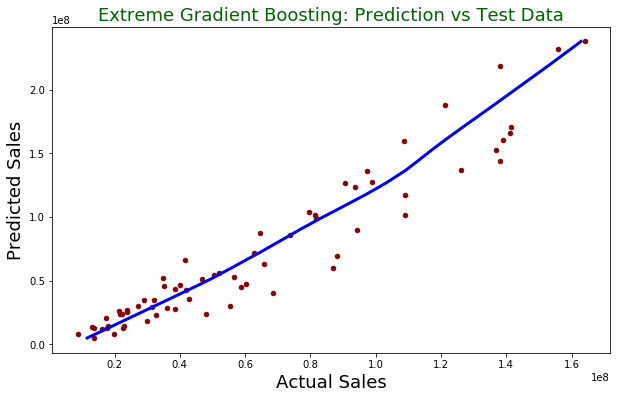

In [74]:
#Creating a plot to check for actual vs Prediction: XGBoost model

plot_data = df_model_cv_prediction[['US_Revenue', 'mean']]
lowess = sm.nonparametric.lowess
observed = plot_data[['US_Revenue']].to_numpy()
prediction = plot_data[['mean']].to_numpy()

test = ({"prediction": prediction, "observed": observed})
z = lowess(prediction.flatten(), observed.flatten())

plot_data.plot(figsize = [10,6], x = "mean", y = "US_Revenue", kind = "scatter", color = "darkred")
plt.title("Extreme Gradient Boosting: Prediction vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Actual Sales", fontsize = 18)
plt.ylabel("Predicted Sales", fontsize = 18)
plt.plot(z[:,1], z[:,0], color = "blue", lw = 3)
plt.show()

In [75]:
### Cross Validation for Linear Regression
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_rev_vif)
print(df_rev_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
lm= linear_model.LinearRegression()
np.random.seed(7)
predictions = cross_val_predict(lm, df_rev_vif,df_transformed['US_Revenue'], cv=8) 
#print(predictions)
scores = cross_validate(lm,df_rev_vif,df_transformed['US_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(67, 10)
4


In [76]:
#Checking the output from Linear Regression
print(scores['estimator'][0].predict(df_rev_vif))
scores['estimator'][0].intercept_

[6.46991179e+07 6.60942699e+07 6.54347309e+07 6.50100444e+07
 8.07277631e+07 6.56081102e+07 6.47874190e+07 6.65904230e+07
 7.06377048e+07 7.05823882e+07 6.53591071e+07 6.47886634e+07
 6.51650978e+07 6.47344686e+07 1.01101895e+08 7.06526676e+07
 4.06491553e+07 6.56978507e+07 9.14003833e+07 6.46993322e+07
 6.47022767e+07 6.47694697e+07 6.46999136e+07 6.57919483e+07
 6.46983464e+07 6.46984713e+07 6.47054179e+07 6.49763988e+07
 6.47171465e+07 6.55256656e+07 6.49124418e+07 6.47386566e+07
 6.53932797e+07 6.50251574e+07 1.45422325e+08 6.46657727e+07
 6.47004060e+07 6.47690337e+07 6.55256656e+07 6.47000482e+07
 6.47130307e+07 1.26162400e+08 6.47423077e+07 6.48903559e+07
 6.56606422e+07 7.26493693e+07 6.38281601e+07 6.47927864e+07
 6.50893913e+07 6.47000908e+07 6.55246437e+07 6.56232631e+07
 7.06599690e+07 6.35148705e+07 6.47920996e+07 6.54170553e+07
 6.47001945e+07 6.61895600e+07 6.46983107e+07 6.48191108e+07
 6.55262276e+07 6.47034143e+07 6.56509555e+07 6.63775187e+07
 6.46995626e+07 6.469827

64698039.9705005

In [5]:
#Printing the scores from the linear regression model
scores

In [78]:
#Checking the model metrics from the linear regression model

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())
# print(scores['test_wmape'].mean())
# print(scores['test_wmape'].mean())

604.4873165865122
63.52632968749933
0.07732974479640735
0.026648805683975874


In [7]:
#Getting the Revenue predictions from the model
scores['estimator'][1].predict(df_rev_vif)
df_model_cv_prediction = df_transformed[['US_Revenue']]
count = 0
for model in scores['estimator']:
    pred = model.predict(df_rev_vif)
    df_model_cv_prediction['model_'+str(count)] = pred
    count = count+1
df_model_cv_prediction

In [80]:
#Collating the dataframe with the actual versus prediction

df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
df_model_cv_prediction[['US_Revenue','mean']]

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


US_Revenue          mean
0   1.458897e+07  6.040552e+07
1   8.611137e+07  7.072064e+07
2   9.877498e+07  7.088707e+07
3   1.266272e+08  7.334094e+07
4   1.598051e+08  1.012254e+08
..           ...           ...
66  5.416103e+07  6.623461e+07
67  1.042348e+08  7.478730e+07
68  2.547165e+07  6.161528e+07
69  4.942026e+06  5.933277e+07
70  2.972428e+07  6.207820e+07

[67 rows x 2 columns]

In [81]:
#Printing out the cross-validation output
df_model_cv_prediction[['US_Revenue','mean']].to_excel(path+"//8fold_CV_Pre_v4_625.xlsx")

In [82]:
## Cross Validation for Random Forest Regressor
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_rev_vif)
print(df_rev_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(df_rev_vif.shape[1]/3),random_state=7)
predictions = cross_val_predict(rf, df_rev_vif,df_transformed['US_Revenue'], cv=8) 
scores = cross_validate(rf,df_rev_vif,df_transformed['US_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(67, 10)
4


In [8]:
#import pandas.rpy.common as com
#Create a correlation plot based on need

#import seaborn as sns
#%matplotlib inline
#corr = df_rev_vif.corr()
#corr.to_excel(path+"\\corr10features.xlsx")
#fig, ax = plt.subplots(figsize=(10, 10))
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = 1
#sns_plot = sns.heatmap(corr,mask=mask,ax=ax,annot=True)
#fig = sns_plot.get_figure()
#fig.savefig(path+"\\corr_plot.png")
#sns_plot
#corr.to_excel(path+"correlation_plot.xlsx")

In [88]:
#Checking the feature importances of the model
scores['estimator'][0].feature_importances_

array([0.15400013, 0.22333019, 0.09087568, 0.08196244, 0.16690291,
       0.05363808, 0.07307524, 0.04417188, 0.0750603 , 0.03698316])

In [89]:
#Printing model error metrics
print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())

49.430342743161724
17.732450217974733
0.9220042964918969
0.9177186595444772


In [86]:
#Exporting the predictions & actual values 
#Exporting the feature importances of the variables in place

df_model_cv_prediction = df_transformed[['US_Revenue']]
feature_importances = pd.DataFrame()
feature_importances['Features'] = df_rev_vif.columns
count = 0
for model in scores['estimator']:
    pred = model.predict(df_rev_vif)
    feat_imp = model.feature_importances_
    df_model_cv_prediction['model_'+str(count)] = pred
    feature_importances['model_'+str(count)] = feat_imp
    count = count+1
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
df_model_cv_prediction.shape
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean',inplace=True,ascending=False)
feature_importances[['Features','mean']].to_excel(path+"//RF_feature_importances_new_US_Pre_fin_Cis_625.xlsx")
df_model_cv_prediction[['US_Revenue','mean']].to_excel(path+"//US_Pre_best_fin_0625_Cis_pred.xlsx")

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [87]:
#Printing the top features from the model's output

#df_model_cv_prediction
feature_importances[['Features','mean']]

Features      mean
1                Nielsen - Metrics First Choice_mean  0.198788
4                                     Google_US_mean  0.149852
0  squareRoot(Nielsen - Metrics Unaided Awareness...  0.144048
2  cube(Nielsen - Metrics Purchase interest - Def...  0.095116
8           cube(Netbase - Metrics Impressions_mean)  0.094422
3           squareRoot(Tubular - Metrics Views_mean)  0.093122
6           cube(Tubular - Metrics Engagements_mean)  0.079576
5   squareRoot(Marketing Metrics Net Sentiment_mean)  0.060320
7              cube(Netbase - Metrics Mentions_mean)  0.048961
9          cube(Netbase - Metrics Totalreplies_mean)  0.035796

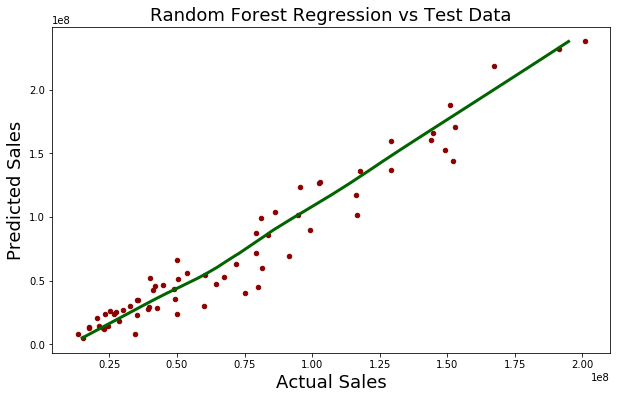

In [57]:
#Plotting the actual revenue versus prediction from the Random Forest Regression model

plot_data = df_model_cv_prediction[['US_Revenue', 'mean']]
lowess = sm.nonparametric.lowess
observed = plot_data[['US_Revenue']].to_numpy()
prediction = plot_data[['mean']].to_numpy()

test = ({"prediction": prediction, "observed": observed})
z = lowess(prediction.flatten(), observed.flatten())

plot_data.plot(figsize = [10,6], x = "mean", y = "US_Revenue", kind = "scatter", color = "darkred")
plt.title("Random Forest Regression vs Test Data", fontsize = 18, color = "black")
plt.xlabel("Actual Sales", fontsize = 18)
plt.ylabel("Predicted Sales", fontsize = 18)
plt.plot(z[:,1], z[:,0], color = "darkgreen", lw = 3)
plt.show()

In [75]:
## Cross Validation for XGB

import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
import xgboost as xgb

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_rev_vif)
print(df_rev_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
gbm= xgb.XGBRegressor(n_estimators=1000,max_depth=6,max_features=int(df_rev_vif.shape[1]/3),random_state=7)
predictions = cross_val_predict(gbm, df_rev_vif,df_transformed['US_Revenue'], cv=8) 
scores = cross_validate(gbm,df_rev_vif,df_transformed['US_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(67, 6)
6
[07:43:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:43:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:35] WARNI

In [78]:
scores

{'fit_time': array([0.16156197, 0.15658188, 0.16060686, 0.17852211, 0.17154121,
        0.16951084, 0.15059686, 0.17150092]),
 'score_time': array([0.00797987, 0.00698113, 0.0059495 , 0.00598454, 0.00701737,
        0.00598478, 0.00701666, 0.00598431]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
               max_depth=6, max_features=2, min_child_weight=1, missing=None,
               n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
               random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=1, verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
         

In [10]:
#Model outputs from XGB model

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())